# A3C 

> A3C全名(asynchronous advantage actor- critic)，顾名思义将策略方法与Q值方法进行融合，实现的一个高效强化学习训练算法。

* q学习，就是将环境与动作组合起来的一种学习方式，比如

||a1|a2|a3|a4|
|:-:|:-:|:-:|:-:|:-:|
|s1|2|3|1|4|
|s2|1|3|0|2|
|s3|2|4|1|2|



### Q学习
上述的表格描述的是，在状态s1,各个动作对应的Q值分别为2，3，1，4，那么根据Q学习，则选择最大的，但是一般来说贪心法容易进入局部最优解，于是采取一定的概率随机选择非最大值对应的动作。可以看出，这种Q表学习方式只能在有限的状态下以及有限的动作下进行建表学习，一旦对于玩**atari**那种游戏，对于空间的要求是特别高的，于是在13年就提出了深度学习Q学习，原理是使用网络来输出Q值

1. 当前状态下的q值$Q = model(s)$
2. 下一个状态的q值$Q^{'}=model(s^{'})$
3. 下一个状态的期望值表达$Q=R+ \gamma \max_{a^{'}}   Q(s)$
4. loss即为1 3的差

### 策略梯度
而策略梯度学习则不一样，输入的为状态，输出则是各个动作的概率，从而能够实现端到端的学习，具体推导就自行看书。


### A2C
顾名思义就是将Q学习与策略梯度结合起来进行学习的一种方式，网络如下,对应论文为[A3C](http://proceedings.mlr.press/v48/mniha16.pdf)

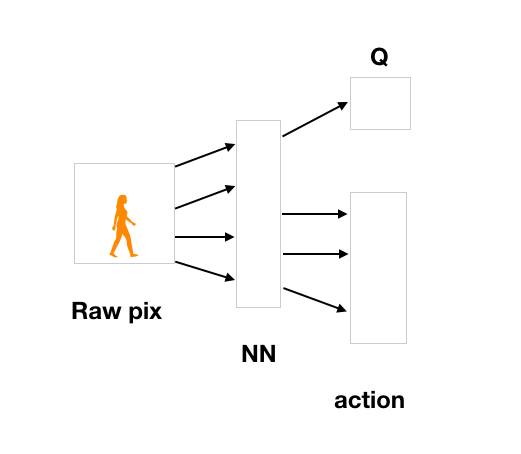

In [2]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda:3" if use_cuda else "cpu")

In [5]:
# 定义异步
from multiprocessing_env import SubprocVecEnv

num_envs = 4
env_name = "CartPole-v0"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Process Process-65:
Process Process-68:
Process Process-66:
Traceback (most recent call last):
Process Process-67:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/b418-xiwei/anaconda3/envs/dl/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, 

In [6]:
# 定义网络
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [7]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward

In [8]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [9]:
# 进行网络初始化
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.n

#Hyper params:
hidden_size = 256
lr          = 3e-4
num_steps   = 5

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

In [10]:
max_frames   = 2000000
frame_idx    = 0
test_rewards = []

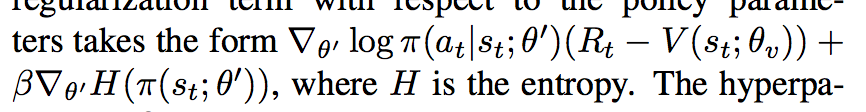

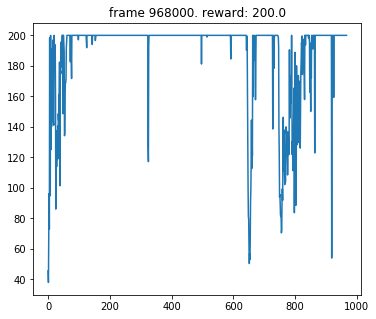

KeyboardInterrupt: 

In [11]:
state = envs.reset()

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_returns(next_value, rewards, masks)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)

    advantage = returns - values   #根据论文定义advantage

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()